**Check if TensorFlow is built with CUDA (GPU) support**

In [1]:
import tensorflow as tf

print("Built with CUDA:", tf.test.is_built_with_cuda())

# listing the available devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
for device in physical_devices:
    print(device)

2024-06-12 11:19:50.956251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 11:19:50.956323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 11:19:50.957425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 11:19:50.965201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 11:19:51.902899: W tensorflow/compiler/tf2

Built with CUDA: True
Num GPUs Available:  3
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')


In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3


2024-06-12 11:19:53.411391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 838 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-06-12 11:19:53.413736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 832 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6
2024-06-12 11:19:53.415535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 872 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

**Read dataset**

In [4]:
filtered_clothing = pd.read_csv('../../filtered_clothing_dataset.csv')

**Split dataset in training and testing set**

In [5]:
eighty_pct = int(0.8*len(filtered_clothing))
  
train_set = filtered_clothing.iloc[:(eighty_pct-1), :] 
test_set = filtered_clothing.iloc[eighty_pct:, :] 
  
train_set.to_csv("train_data.csv", index=False)
test_set.to_csv("test_data.csv", index=False)

**Loading the dataset**

In [6]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [7]:
# image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data['id'] = train_data['id'].astype(str) + '.jpg'
test_data['id'] = test_data['id'].astype(str) + '.jpg'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True) 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 22344 validated image filenames belonging to 24 classes.
Found 5587 validated image filenames belonging to 24 classes.


**Adding custom classification head on top of the pretrained model MobileNetV2 and compiling the model**

In [8]:
with strategy.scope():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(24, activation='softmax')  # 24 main subcategories in the dataset
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

**Model training**

In [9]:
# number of training and validation steps
train_steps_per_epoch = len(train_data) // batch_size
test_steps_per_epoch = len(test_data) // batch_size

with strategy.scope():
# model training
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps_per_epoch,
        epochs=10,
        validation_data=test_generator,
        validation_steps=test_steps_per_epoch)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 2 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 2 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-06-12 11:20:10.112284: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-12 11:20:10.131052: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-12 11:20:10.147360: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-12 11:20:12.289404: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0220520fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 11:20:12.289491: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-06-12 11:20:12.289505: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A40, Compute Capability 8.6
2024-06-12 11:20:12.289514: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A40, Compute Capability 8.6
2024-06-12 11:20:12.310735: I tens

698/698 [==============================] - 271s 370ms/step - loss: 0.7550 - accuracy: 0.7449 - val_loss: 0.5939 - val_accuracy: 0.7834
Epoch 2/10
698/698 [==============================] - 262s 375ms/step - loss: 0.5128 - accuracy: 0.8158 - val_loss: 0.5457 - val_accuracy: 0.8080
Epoch 3/10
698/698 [==============================] - 266s 380ms/step - loss: 0.4634 - accuracy: 0.8300 - val_loss: 0.5474 - val_accuracy: 0.8060
Epoch 4/10
698/698 [==============================] - 260s 372ms/step - loss: 0.4299 - accuracy: 0.8438 - val_loss: 0.5047 - val_accuracy: 0.8208
Epoch 5/10
698/698 [==============================] - 259s 371ms/step - loss: 0.4086 - accuracy: 0.8498 - val_loss: 0.5695 - val_accuracy: 0.7997
Epoch 6/10
698/698 [==============================] - 243s 347ms/step - loss: 0.3836 - accuracy: 0.8566 - val_loss: 0.5644 - val_accuracy: 0.8093
Epoch 7/10
698/698 [==============================] - 275s 393ms/step - loss: 0.3707 - accuracy: 0.8645 - val_loss: 0.5495 - val_accura

**Saving the model**

In [10]:
model.save('MobileNetV2_model_12062024_article_10epochs_gpu.keras')
print("Saving the model as MobileNetV2_model_12062024_article_10epochs_gpu.keras")

Saving the model as MobileNetV2_model_12062024_article_10epochs_gpu.keras


**Model evaluation**

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# predicting the probabilities for the test set
y_pred_proba = model.predict(test_generator)

# converting the probabilities to class predictions
y_pred = np.argmax(y_pred_proba, axis=1)

# getting the true labels
y_true = test_generator.classes

# computing the precision, recall, f1-score, support
print("Classification Report:")
print(classification_report(y_true, y_pred))

# computing the AUC-ROC score with the multi_class='ovr'
auc_roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
print("AUC-ROC Score (ovr):", auc_roc)

# computing the AUC-ROC score with the multi_class='ovo'
auc_roc_ovo = roc_auc_score(y_true, y_pred_proba, multi_class='ovo')
print("AUC-ROC Score (ovo):", auc_roc_ovo)

174/174 [==============================] - 7s 38ms/step - loss: 0.5252 - accuracy: 0.8226
Test Loss: 0.5251928567886353
Test Accuracy: 0.8225574493408203
175/175 [==============================] - 10s 35ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       134
           1       0.71      0.50      0.59        40
           2       0.78      0.72      0.75       550
           3       0.83      0.94      0.88        63
           4       0.72      0.82      0.77        79
           5       0.36      0.38      0.37       102
           6       0.84      0.84      0.84       187
           7       0.78      0.84      0.81       134
           8       0.97      0.87      0.92       342
           9       0.73      0.79      0.76       259
          10       0.63      0.54      0.58        50
          11       0.73      0.95      0.83       124
          12       0.33      0.64      0.44        14
         

**Accuracy per article type**

175/175 [==============================] - 7s 37ms/step
Accuracy for subcategory 'Backpacks': 0.9477611940298507
Accuracy for subcategory 'Capris': 0.5
Accuracy for subcategory 'Casual Shoes': 0.7163636363636363
Accuracy for subcategory 'Clutches': 0.9365079365079365
Accuracy for subcategory 'Dresses': 0.8227848101265823
Accuracy for subcategory 'Flats': 0.38235294117647056
Accuracy for subcategory 'Flip Flops': 0.8449197860962567
Accuracy for subcategory 'Formal Shoes': 0.835820895522388
Accuracy for subcategory 'Handbags': 0.868421052631579
Accuracy for subcategory 'Heels': 0.7915057915057915
Accuracy for subcategory 'Jackets': 0.54
Accuracy for subcategory 'Jeans': 0.9516129032258065
Accuracy for subcategory 'Laptop Bag': 0.6428571428571429
Accuracy for subcategory 'Leggings': 0.7878787878787878
Accuracy for subcategory 'Sandals': 0.6570048309178744
Accuracy for subcategory 'Shirts': 0.9212121212121213
Accuracy for subcategory 'Shorts': 0.9252336448598131
Accuracy for subcategory 'S

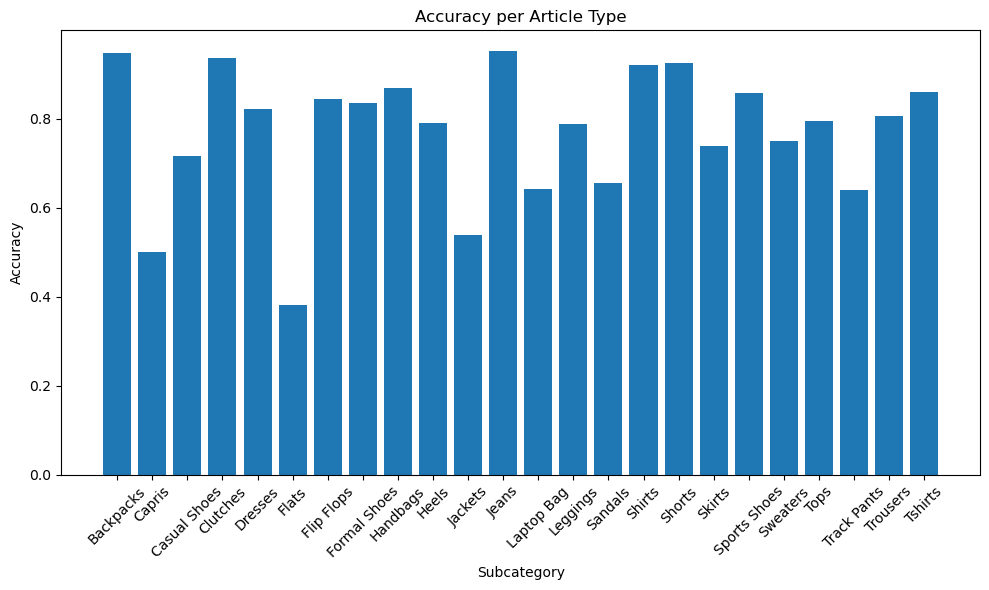

In [12]:
# converting the class_labels to a list
class_labels = list(train_generator.class_indices.keys())

# predicting the probabilities for the test set
predictions = model.predict(test_generator)

# getting the the predicted labels for each image
predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]

# getting the true labels for each image
true_labels = [class_labels[i] for i in test_generator.classes]

# initializing a dictionary to store the counts of the correct predictions and the total counts for each subcategory
subcategory_counts = {class_label: [0, 0] for class_label in class_labels}

# iterating through each prediction and updating the counts
for true_label, predicted_label in zip(true_labels, predicted_labels):
    subcategory_counts[true_label][1] += 1
    if true_label == predicted_label:
        subcategory_counts[true_label][0] += 1

# computing the accuracy for each subcategory
subcategory_accuracies = {class_label: (count[0] / count[1]) if count[1] != 0 else 0 for class_label, count in subcategory_counts.items()}

# displaying the accuracy per subcategory
for class_label, accuracy in subcategory_accuracies.items():
    print(f"Accuracy for subcategory '{class_label}': {accuracy}")

# plotting the accuracy per subcategory
plt.figure(figsize=(10, 6)) 
plt.bar(subcategory_accuracies.keys(), subcategory_accuracies.values())
plt.xlabel('Subcategory')
plt.ylabel('Accuracy')
plt.title('Accuracy per Article Type')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

**Saving the History Object**

In [13]:
import pickle

with open('history_mobileNetV2_12062024_article_10epochs.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

**Plotting the history**

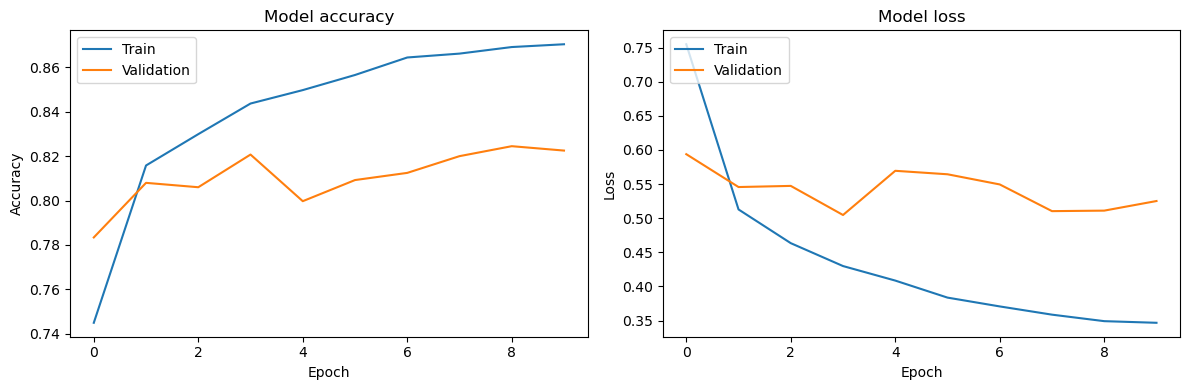

In [14]:
# loading the history object
with open('history_mobileNetV2_12062024_article_10epochs.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

# plotting the training & validation accuracy and the loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Predict the label and accuracy of an external image**

1/1 [==============================] - 3s 3s/step


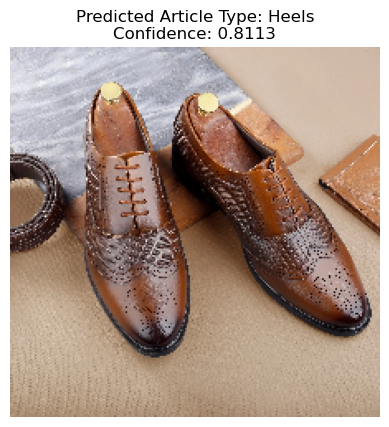

1/1 [==============================] - 0s 294ms/step


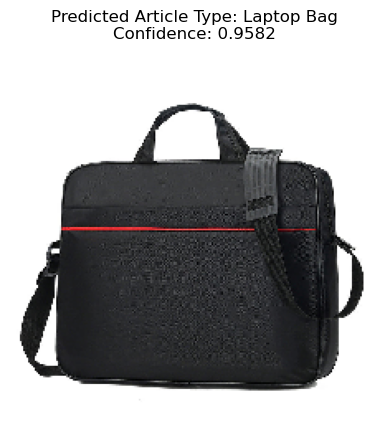

1/1 [==============================] - 0s 255ms/step


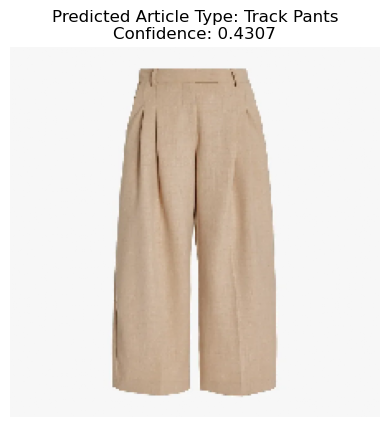

1/1 [==============================] - 0s 223ms/step


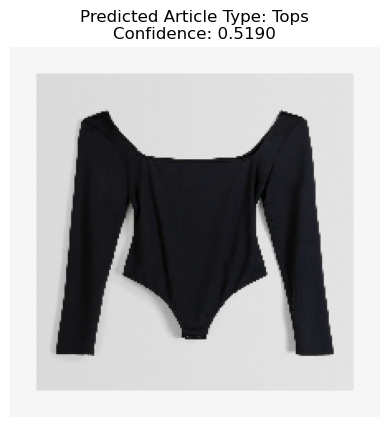

1/1 [==============================] - 0s 199ms/step


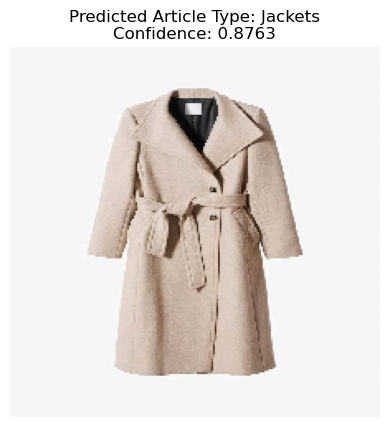

1/1 [==============================] - 0s 191ms/step


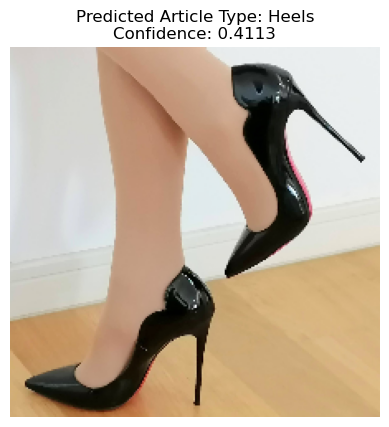

1/1 [==============================] - 0s 189ms/step


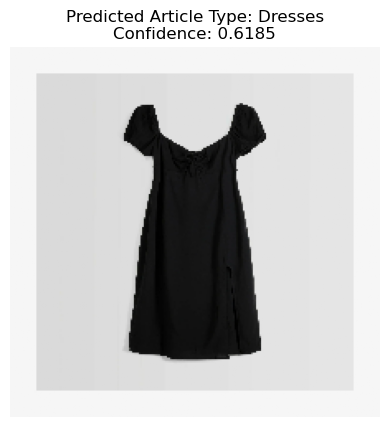

1/1 [==============================] - 1s 654ms/step


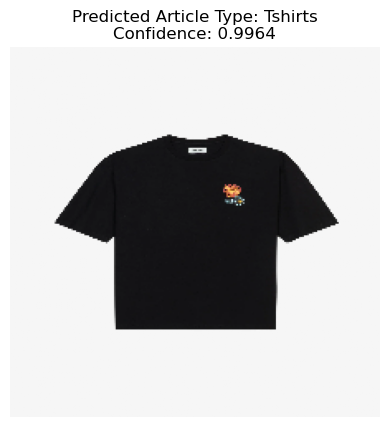

1/1 [==============================] - 0s 196ms/step


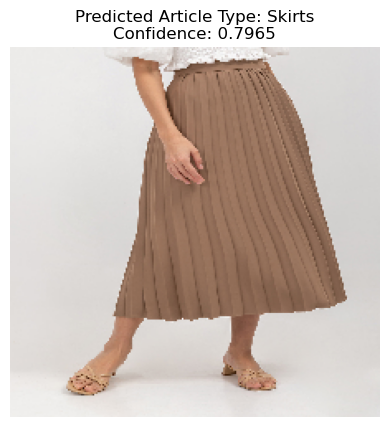

1/1 [==============================] - 0s 258ms/step


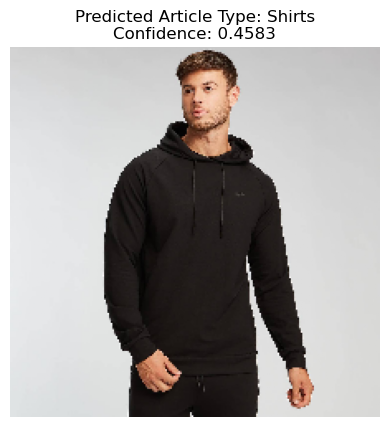

1/1 [==============================] - 0s 256ms/step


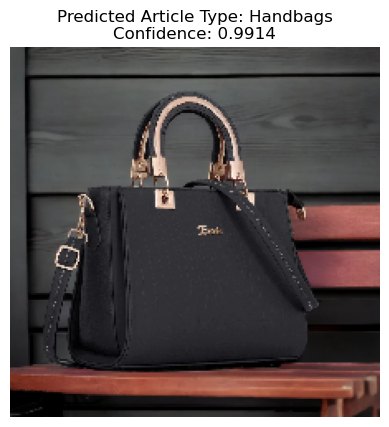

1/1 [==============================] - 0s 256ms/step


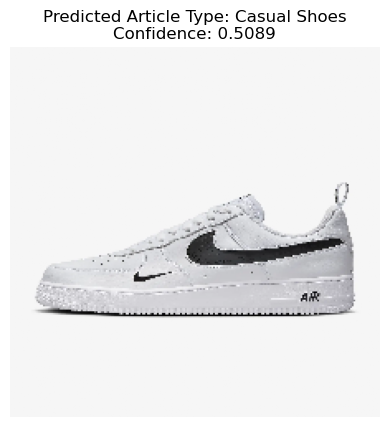

1/1 [==============================] - 0s 256ms/step


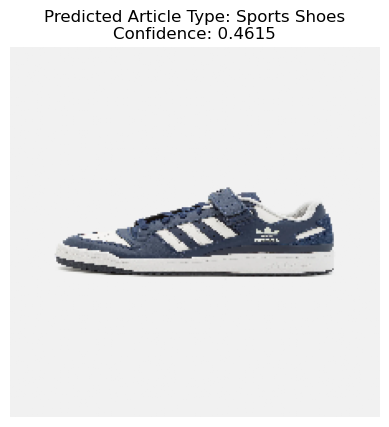

1/1 [==============================] - 0s 252ms/step


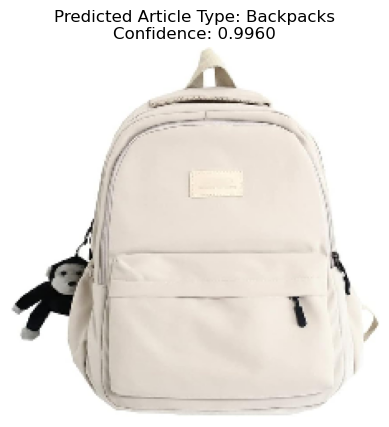

1/1 [==============================] - 0s 251ms/step


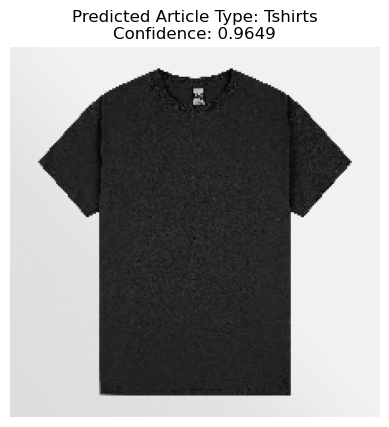

1/1 [==============================] - 0s 245ms/step


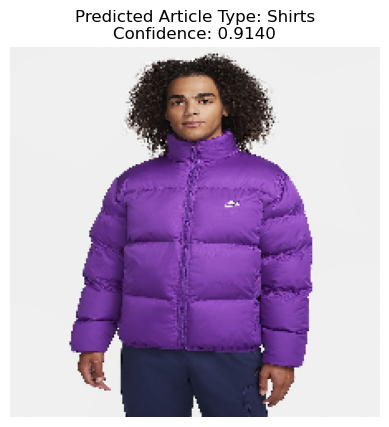

1/1 [==============================] - 0s 214ms/step


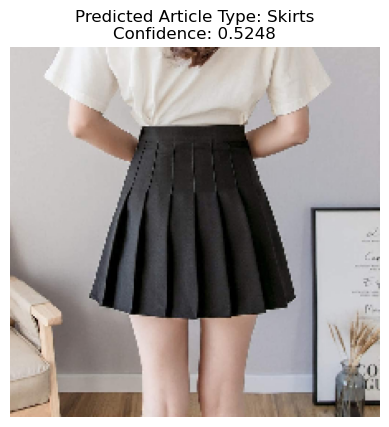

1/1 [==============================] - 0s 196ms/step


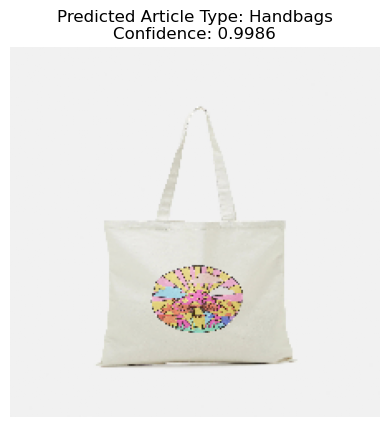

1/1 [==============================] - 0s 193ms/step


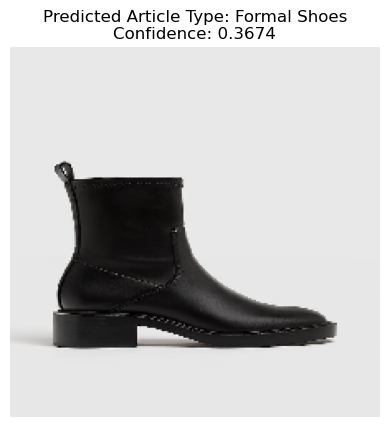

1/1 [==============================] - 0s 202ms/step


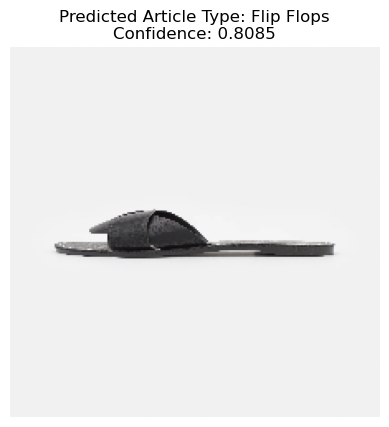

1/1 [==============================] - 0s 192ms/step


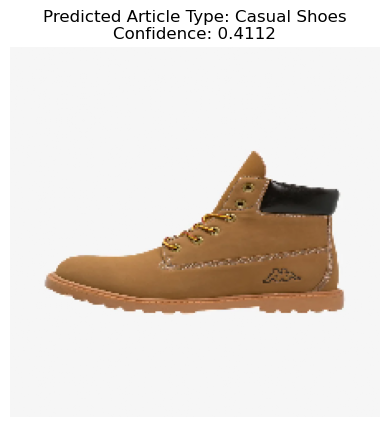

1/1 [==============================] - 0s 192ms/step


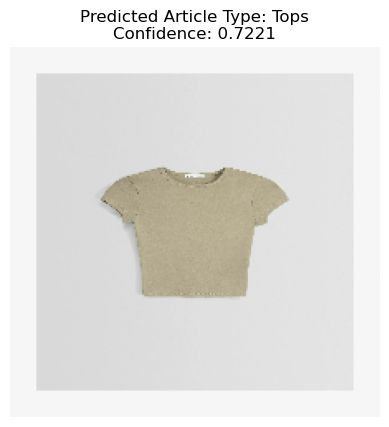

1/1 [==============================] - 0s 190ms/step


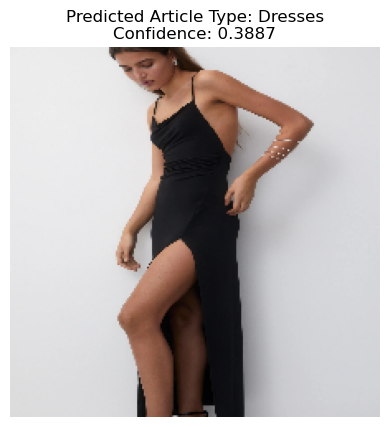

1/1 [==============================] - 0s 192ms/step


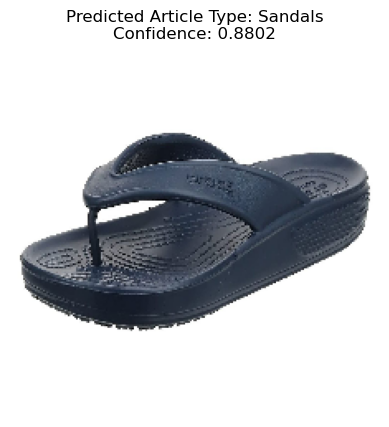

1/1 [==============================] - 0s 196ms/step


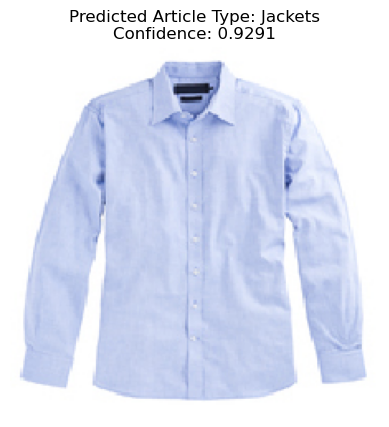

1/1 [==============================] - 0s 191ms/step


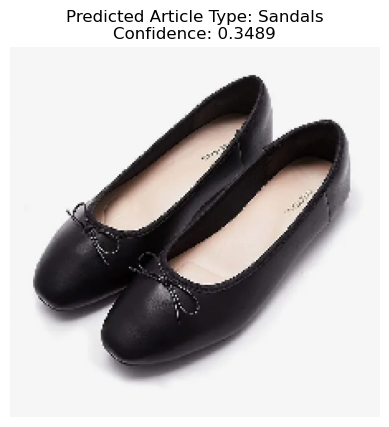

1/1 [==============================] - 0s 200ms/step


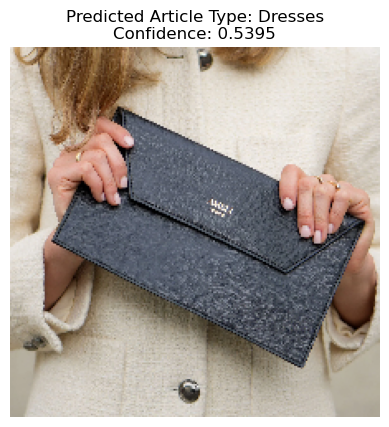

1/1 [==============================] - 0s 190ms/step


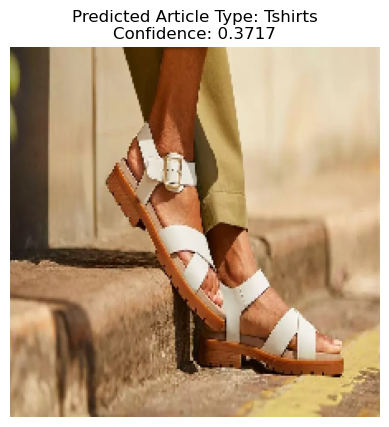

1/1 [==============================] - 0s 192ms/step


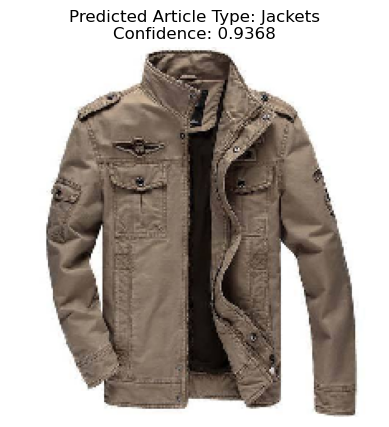

1/1 [==============================] - 0s 307ms/step


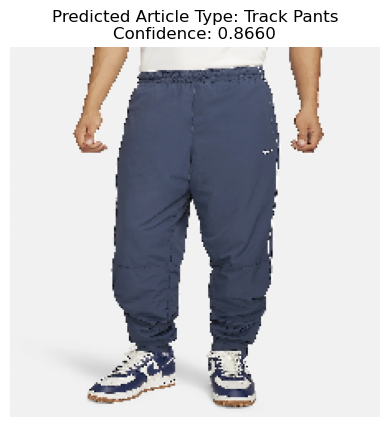

1/1 [==============================] - 0s 305ms/step


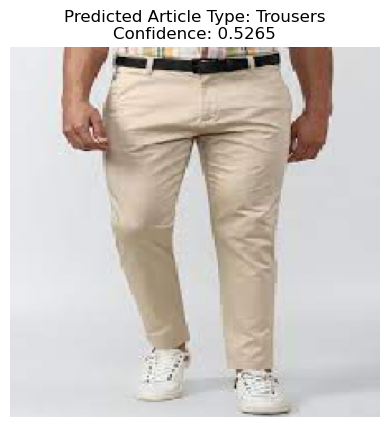

1/1 [==============================] - 0s 306ms/step


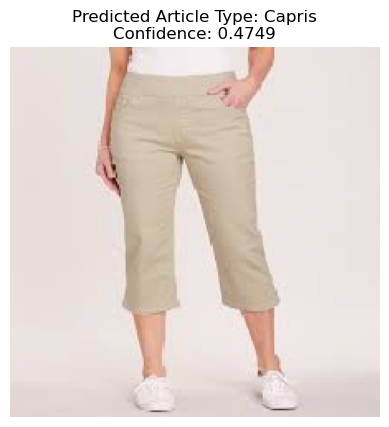

1/1 [==============================] - 0s 254ms/step


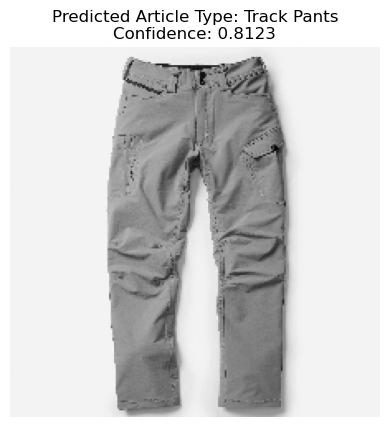

1/1 [==============================] - 0s 264ms/step


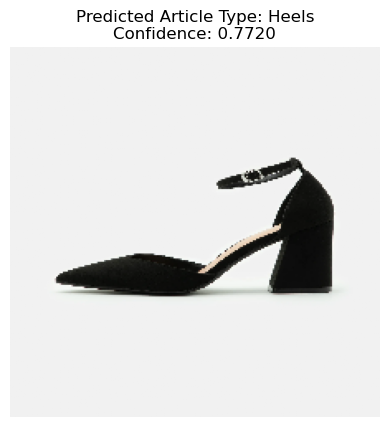

1/1 [==============================] - 0s 253ms/step


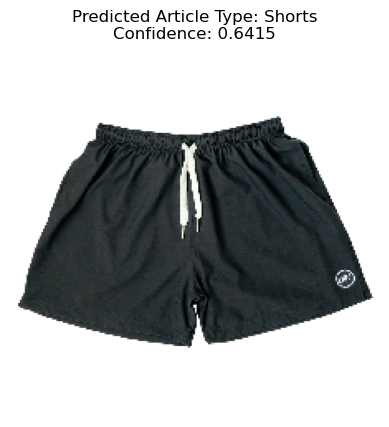

In [15]:
# function to make predictions with dynamically generated category labels
def predict_image_category_with_dynamic_labels(image_path, model, train_generator):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    # getting the index of the class with the highest probability
    predicted_class = np.argmax(predictions[0])  
    
    # generating a mapping of the class indices to category labels
    class_labels = {i: label for i, label in enumerate(train_generator.class_indices.keys())}

    # getting the corresponding label using the class index
    predicted_label = class_labels[predicted_class]  

    # computing the confidence score of the prediction
    confidence = predictions[0][predicted_class]  
    
    return predicted_label, confidence, img_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

def parse_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.webp', '.hpg', '.png'))]
    images_data = []
    for file in image_files:
        image_path = os.path.join(folder_path, file)
        preprocessed_image = preprocess_image(image_path)
        images_data.append((image_path, preprocessed_image)) 
    return images_data


images_folder_path = '../../clothing_test_dataset/'

images_data = parse_images_in_folder(images_folder_path)

for image_path, preprocessed_image in images_data:
    # predicting the category and the confidence for the image
    predicted_label, confidence, img_array = predict_image_category_with_dynamic_labels(image_path, model, train_generator)
    
    # displaying the image along with the predicted category and confidence
    plt.imshow(img_array[0])
    plt.title(f'Predicted Article Type: {predicted_label}\nConfidence: {confidence:.4f}')
    plt.axis('off')
    plt.show()
